/tmp/ipykernel_594383/3549824615.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


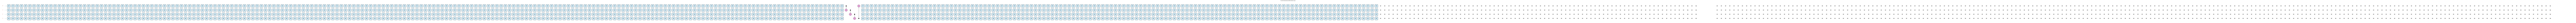

Epochs:   0%|          | 0/10 [00:20<?, ?it/s]

 Epoch 1 | Batch 1/350 | batch_loss=0.9125


Epochs:   0%|          | 0/10 [00:40<?, ?it/s]

 Epoch 1 | Batch 2/350 | batch_loss=1.1543


Epochs:   0%|          | 0/10 [01:01<?, ?it/s]

 Epoch 1 | Batch 3/350 | batch_loss=0.9935


Epochs:   0%|          | 0/10 [01:22<?, ?it/s]

 Epoch 1 | Batch 4/350 | batch_loss=1.0071


Epochs:   0%|          | 0/10 [01:43<?, ?it/s]

 Epoch 1 | Batch 5/350 | batch_loss=1.1420


Epochs:   0%|          | 0/10 [02:04<?, ?it/s]

 Epoch 1 | Batch 6/350 | batch_loss=1.0066


Epochs:   0%|          | 0/10 [02:23<?, ?it/s]

 Epoch 1 | Batch 7/350 | batch_loss=1.1427


Epochs:   0%|          | 0/10 [02:41<?, ?it/s]

 Epoch 1 | Batch 8/350 | batch_loss=0.9541


Epochs:   0%|          | 0/10 [02:50<?, ?it/s]


KeyboardInterrupt: 

In [5]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm  # 进度条库
import logging
import matplotlib.pyplot as plt

# ─────────────── 日志配置 ───────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger()

# ─────────────── 数据加载与预处理 ───────────────
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
mask = (y == "0") | (y == "1")
X, y = X[mask] / 255 * np.pi, y[mask].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ─────────────── 超参与设备 ───────────────
n_qubits   = 4
chunk_size = n_qubits
n_chunks   = X.shape[1] // chunk_size  # 196
n_layers   = 3

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def reupload_qnn(x, weights):
    for l in range(n_layers):
        # 分块编码
        for i in range(n_chunks):
            base = i * chunk_size
            for q in range(chunk_size):
                qml.RY(x[base + q], wires=q)
        # 可训练旋转
        for q in range(n_qubits):
            qml.RX(weights[l, q, 0], wires=q)
            qml.RY(weights[l, q, 1], wires=q)
            qml.RZ(weights[l, q, 2], wires=q)
        # 环形纠缠
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q + 1) % n_qubits])
    return qml.expval(qml.PauliZ(0))

# ─────────────── 批次训练设置 ───────────────
batch_size = 32
n_batches = len(X_train) // batch_size

# ─────────────── 初始化 & 优化器 ───────────────
np.random.seed(0)
weights = np.random.normal(0, np.pi, (n_layers, n_qubits, 3), requires_grad=True)
opt     = qml.GradientDescentOptimizer(stepsize=0.1)

# ─────────────── 彩色电路图 ───────────────
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(
    reupload_qnn,
    wire_order=range(n_qubits),
    show_all_wires=True,
    style="pennylane",
    wire_options={"color": "teal", "linewidth": 2},
    label_options={"size": 10, "color": "darkred"},
    max_length=2000,  # 全部展开
)(X_train[0], weights)

ax.set_title("Chunked Reuploading QNN (Detailed Logs)", pad=16)
plt.tight_layout()
plt.show()

epochs  = 10

# ─────────────── 训练循环 ───────────────
for epoch in trange(1, epochs + 1, desc="Epochs"):
    epoch_loss = 0.0

    # 逐批次更新
    for b in range(n_batches):
        start = b * batch_size
        end   = start + batch_size
        Xb, yb = X_train[start:end], y_train[start:end]

        def batch_loss(w):
            preds = np.array([reupload_qnn(x, w) for x in Xb])
            return np.mean((preds - (1 - 2 * yb)) ** 2)

        weights, loss_b = opt.step_and_cost(batch_loss, weights)
        epoch_loss += loss_b

        # 打印每个 batch 的 loss
        tqdm.write(f" Epoch {epoch} | Batch {b+1}/{n_batches} | batch_loss={loss_b:.4f}")

    # 计算 epoch 平均 loss 与 accuracy
    avg_loss = epoch_loss / n_batches
    train_out = np.array([reupload_qnn(x, weights) for x in X_train]) > 0
    test_out  = np.array([reupload_qnn(x, weights) for x in X_test ]) > 0
    train_acc = np.mean(train_out == (y_train == 0))
    test_acc  = np.mean(test_out  == (y_test  == 0))

    logger.info(
        f"[Epoch {epoch:2d}] avg_loss={avg_loss:.4f}  "
        f"train_acc={train_acc:.3f}  test_acc={test_acc:.3f}"
    )
